# Feature Engineering and Modeling

In this notebook, I will build upon the preprocessed dataset created in the `01_data_loading_and_exploration.ipynb` notebook. Here, I will:

1. Perform a brief correlation analysis on numeric features to gain additional insight into the data.
2. Train a baseline machine learning model (e.g., Logistic Regression) to establish a performance benchmark.
3. Attempt a second baseline model (a simple Decision Tree) for comparison.
4. Evaluate the models using appropriate metrics.
5. Discuss potential improvements and next steps for more advanced modeling.

By the end of this notebook, I should have a solid understanding of how well simple models perform on the credit risk dataset and what areas may require more sophisticated techniques or tuning.

In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the previously saved train_test splits
X_train = joblib.load("../data/X_train.pkl")
X_test = joblib.load("../data/X_test.pkl")
y_train = joblib.load("../data/y_train.pkl")
y_test = joblib.load("../data/y_test.pkl")

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (800, 48)
X_test shape: (200, 48)
y_train shape: (800,)
y_test shape: (200,)


### Quick Correlation Analysis of Numeric Features

Before modeling, let’s quickly examine the correlation between numeric features. While we have many encoded features, focusing on the original numeric variables can still provide insight into relationships that might affect modeling.

**Why Do This?**  
- Correlation can highlight redundant features or unexpected relationships.
- Although the dataset is already encoded, understanding numeric interactions can inform feature selection or transformation.

I will select the original numeric columns identified in the previous notebook and plot a correlation matrix.

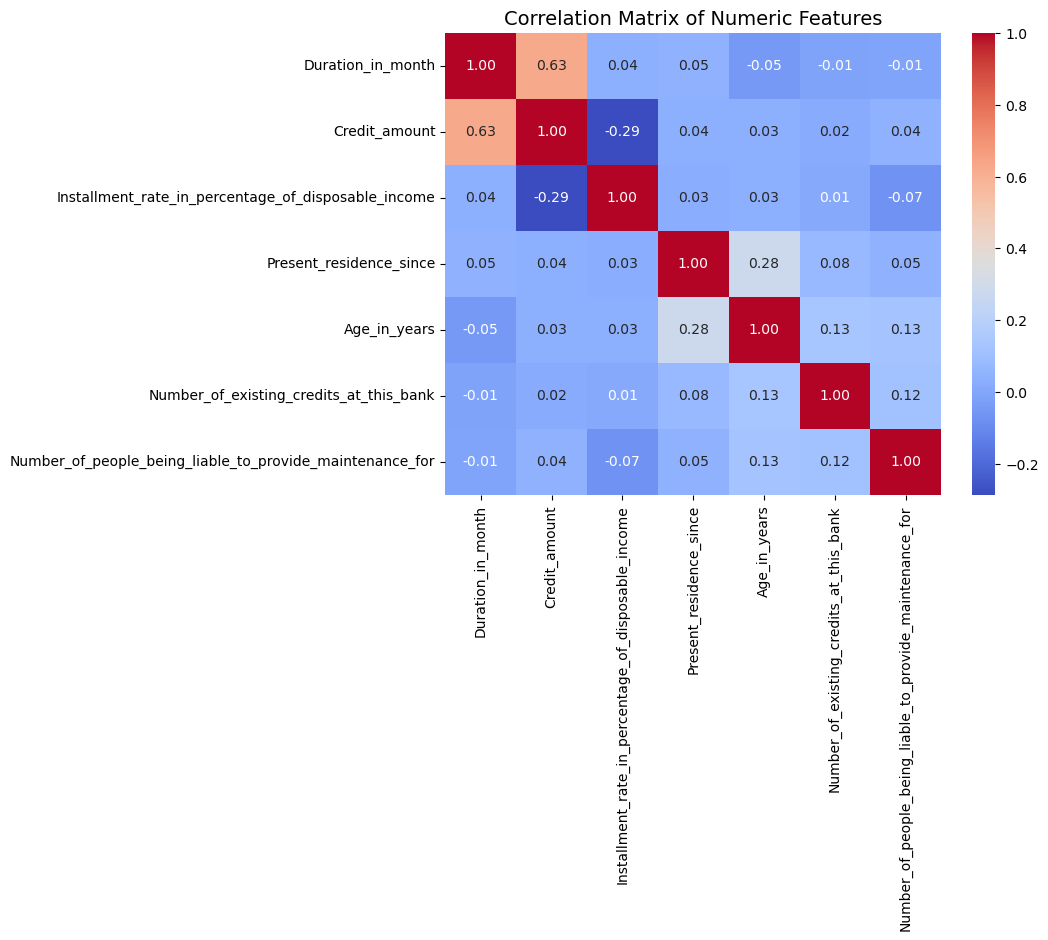

In [7]:
# Identify numeric columns from previous notebook context
numeric_cols = [
    "Duration_in_month", 
    "Credit_amount",
    "Installment_rate_in_percentage_of_disposable_income", 
    "Present_residence_since", 
    "Age_in_years",
    "Number_of_existing_credits_at_this_bank", 
    "Number_of_people_being_liable_to_provide_maintenance_for"
]

# Extract only these numeric columns from X_train
numeric_data = X_train[numeric_cols]

# Compute correlation
corr = numeric_data.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numeric Features", fontsize=14)
plt.show()

#### Interpreting the Correlation Matrix of Numeric Features

The correlation matrix above shows how each numeric feature relates to the others. The value of each cell indicates the strength and direction of the linear relationship between two variables, with values near 1.0 or -1.0 indicating strong positive or negative correlations, respectively.

**Key Observations:**

1. **Duration_in_month and Credit_amount (0.63):**  
   This is the strongest correlation observed. Customers taking longer-duration loans often have larger credit amounts. Intuitively, a bigger loan might require a longer repayment period, making this relationship expected.

2. **Most Other Correlations are Weak:**  
   The remaining numeric features (Installment_rate_in_percentage_of_disposable_income, Present_residence_since, Age_in_years, Number_of_existing_credits_at_this_bank, and Number_of_people_being_liable_to_provide_maintenance_for) show weak correlations (mostly between -0.3 and 0.3) with each other and with the main variables. This suggests that these features provide distinct information rather than duplicating what another variable already captures.

3. **Age_in_years Shows Minimal Correlation with Others:**  
   Age does not strongly correlate with loan amount or duration, indicating that age provides independent predictive value that might complement other factors.

4. **Practical Implication for Modeling:**  
   Since no pairs of features are highly correlated (other than Duration_in_month and Credit_amount), we likely don't need to drop or transform variables solely due to redundancy at this stage. The relatively low correlations also mean that each numeric feature can potentially add unique insight to the model. However, for future improvements, we might explore non-linear relationships or consider feature engineering if we suspect more complex interactions.

Overall, the correlation matrix suggests no immediate need for dimensionality reduction or removal of numeric features based solely on redundancy. Each numeric variable may contribute distinct predictive power in the redit risk model.


### Baseline Model: Logistic Regression

Before diving into complex models or extensive parameter tuning, I will start with a simple baseline model. Logistic Regression is a classic linear model often used as a first benchmark in classification tasks. 

**Why Logistic Regression?**  
- It’s straightforward and widely understood, making it an excellent first choice to gauge the difficulty of the prediction problem.
- It runs quickly and gives a point of comparison for more advanced models later.
- If Logistic Regression performs reasonably well, it suggests that linear relationships between features and the target are informative. If it performs poorly, it may indicate that more complex relationships or features are needed.

**What Am I Looking For?**  
- **Accuracy**: How many predictions are correct overall.
- **Precision/Recall/F1-score**: To understand the quality of predictions for each class, especially the "bad" credit class, which might be more critical to identify accurately.
- **Confusion Matrix**: To see if the model predominantly misclassifies one class over the other.

After evaluating Logistic Regression, I’ll know whether I need more advanced techniques (e.g., Random Forests, Gradient Boosted Trees) or additional data transformations. This baseline sets the foundation for all subsequent improvements.

In [11]:
# Initialize a Logistic Regression model with default parameters
model = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

C:\Users\SebastianGM\anaconda3\envs\pd_model_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [3]:
# Evaluate the model
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", acc)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

Accuracy: 0.795

Confusion Matrix:
 [[127  14]
 [ 27  32]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       141
           1       0.70      0.54      0.61        59

    accuracy                           0.80       200
   macro avg       0.76      0.72      0.74       200
weighted avg       0.79      0.80      0.79       200



**Interpretation:**

- **Accuracy (0.795):** The model correctly predicts the credit risk category (good or bad) for approximately 79.5% of the instances. While this is a solid start, it's important to look beyond accuracy to understand the model's performance on each class.

- **Confusion Matrix:**
  - **True Negatives (127):** These are good credit customers correctly identified as good.
  - **False Positives (14):** These are good credit customers incorrectly labeled as bad.
  - **False Negatives (27):** These are bad credit customers incorrectly labeled as good.
  - **True Positives (32):** These are bad credit customers correctly identified as bad.

- **Recall for Class 1 (Bad Credit):** 0.54  
  This means the model correctly identifies 54% of the actual bad credit customers. In a credit risk context, this recall rate is concerning because it implies that nearly half of the bad credit cases are being missed, which could lead to financial losses.

**To improve this baseline:**
- I can scale the features.
- Increase `max_iter`.
- Change the solver to `liblinear` for potentially better convergence.

### Addressing the Convergence Warning

I received a `ConvergenceWarning` which indicates that the Logistic Regression model did not fully converge within the given number of iterations (`max_iter=1000`). This can happen when:

- Features are on different scales, making it harder for the optimizer to find a stable solution.
- The default solver and iteration limit are insufficient for this particular dataset.

**Why does scaling help?**  
When features vary widely in scale (e.g., some in the hundreds, others less than one), the optimization algorithm struggles to navigate the feature space efficiently. By scaling all features to a similar range (for example, using StandardScaler to give them all a mean of 0 and a standard deviation of 1), the model can converge more easily.

**Why increase `max_iter` or change the solver?**  
If the optimizer doesn’t converge within the default number of iterations, giving it more iterations (`max_iter`) can help. Also, some solvers (like `liblinear`) may handle certain datasets more gracefully, converging faster or more reliably.

**Next Step**: I will scale the data, increase `max_iter`, and use a different solver (`liblinear`) to see if the warning disappears and to ensure the model is properly converged.

In [14]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Re-Initialize Logistic Regression with more iterations and a different solver
model_improved = LogisticRegression(max_iter=2000, solver='liblinear', random_state=42)
model_improved.fit(X_train_scaled, y_train)
y_pred_improved = model_improved.predict(X_test_scaled)

acc_improved = accuracy_score(y_test, y_pred_improved)
cm_improved = confusion_matrix(y_test, y_pred_improved)
report_improved = classification_report(y_test, y_pred_improved)

print("Accuracy (Improved):", acc_improved)
print("\nConfusion Matrix (Improved):\n", cm_improved)
print("\nClassification Report (Improved):\n", report_improved)

Accuracy (Improved): 0.795

Confusion Matrix (Improved):
 [[124  17]
 [ 24  35]]

Classification Report (Improved):
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       141
           1       0.67      0.59      0.63        59

    accuracy                           0.80       200
   macro avg       0.76      0.74      0.74       200
weighted avg       0.79      0.80      0.79       200



**Interpretation:**

To address the convergence warning from the initial Logistic Regression model, I implemented feature scaling using `StandardScaler` and adjusted the solver to `liblinear` with an increased number of iterations (`max_iter=2000`). Here's how these changes impacted the model:

- **Accuracy (0.795):** The overall accuracy remains unchanged at approximately 79.5%, indicating that scaling and solver adjustments did not significantly affect the overall prediction rate.

- **Confusion Matrix (Improved):**
  - **True Negatives (124):** Slight decrease from the initial 127, indicating a small increase in false positives.
  - **False Positives (17):** Increased from 14 to 17, meaning more good credit customers are incorrectly labeled as bad.
  - **False Negatives (24):** Decreased from 27 to 24, showing an improvement in identifying bad credit customers.
  - **True Positives (35):** Increased from 32 to 35, meaning more bad credit customers are correctly identified.

- **Recall for Class 1 (Bad Credit):** 0.59  
  The recall for the bad class improved from 0.54 to 0.59. This means the model now correctly identifies 59% of the actual bad credit customers, which is a noticeable improvement. However, there is still room for further enhancement to ensure that more bad credit cases are captured.

While still not perfect, this improvement shows the value of scaling and solver adjustments. The model now provides a stronger baseline for comparison with other algorithms.

### Trying a Second Baseline Model: Decision Tree

To see if a different class of model might perform better on this dataset without complex tuning, let’s try a simple Decision Tree classifier. Decision Trees:
- Are easy to interpret.
- Can capture non-linear relationships better than Logistic Regression.
- May handle categorical features well (though we already encoded them).

This test will show if a tree-based model can outperform the logistic baseline in terms of recall for bad credit cases.

In [18]:
# Initialize a simple Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)

# Fit the tree on the training data (using the scaled data for consistency)
tree_model.fit(X_train_scaled, y_train)
y_pred_tree = tree_model.predict(X_test_scaled)

acc_tree = accuracy_score(y_test, y_pred_tree)
cm_tree = confusion_matrix(y_test, y_pred_tree)
report_tree = classification_report(y_test, y_pred_tree)

print("Decision Tree Accuracy:", acc_tree)
print("\nConfusion Matrix (Decision Tree):\n", cm_tree)
print("\nClassification Report (Decision Tree):\n", report_tree)

Decision Tree Accuracy: 0.71

Confusion Matrix (Decision Tree):
 [[109  32]
 [ 26  33]]

Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.81      0.77      0.79       141
           1       0.51      0.56      0.53        59

    accuracy                           0.71       200
   macro avg       0.66      0.67      0.66       200
weighted avg       0.72      0.71      0.71       200



#### Evaluating the Decision Tree Model

After training a simple Decision Tree classifier, I obtained the following results:

- **Decision Tree Accuracy:** 0.71 (71%)
- **Confusion Matrix:**
  - True Negatives (109): Good credit customers correctly identified as good.
  - False Positives (32): Good credit customers incorrectly flagged as bad.
  - False Negatives (26): Bad credit customers missed by the model.
  - True Positives (33): Bad credit customers correctly identified.
  
- **Classification Report Highlights:**
  - **Good Credit (Class 0):** Precision ~0.81 and Recall ~0.77. The tree does a decent job identifying good customers.
  - **Bad Credit (Class 1):** Precision ~0.51 and Recall ~0.56. The model struggles more with bad credit cases, catching only a little over half of them.

**Interpretation:**
- The Decision Tree’s accuracy (71%) is lower than the Improved Logistic Regression's (~79.5%), suggesting that, without tuning, the tree model is less effective at overall classification.
- While the tree captures more than half of the bad credit customers (Recall = 0.56), this is still lower than the improved Logistic Regression's recall (~0.59). Thus, the Decision Tree does not provide a clear advantage over Logistic Regression in terms of identifying high-risk customers.
- The Decision Tree’s performance might improve with hyperparameter tuning (e.g., limiting max_depth, adjusting min_samples_split) to reduce overfitting or focusing on cost-sensitive metrics to better handle the minority class.

**Business Implication:**
In a credit risk scenario, failing to identify bad credit customers can lead to financial losses. While the Decision Tree offers a different approach from Logistic Regression, its current configuration does not outperform the baseline in identifying the minority class. This suggests that more sophisticated techniques—such as Random Forests, Gradient Boosted Trees, or parameter tuning—may be necessary to achieve better recall for bad credit cases.

**Next Steps:**
- Try advanced tree-based methods (e.g., Random Forest or XGBoost) known for improved performance in tabular data.
- Experiment with class weighting or threshold adjustments to prioritize catching bad credit customers.
- Consider hyperparameter tuning for the Decision Tree to see if it can match or surpass Logistic Regression’s performance.

These steps will help move closer to a model that balances both accuracy and the critical recall metric for bad credit, ultimately making the model more valuable for a lending institution.